In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import eli5
import seaborn as sns
%matplotlib inline

In [151]:
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE
from eli5.sklearn import PermutationImportance
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score # 정확도 함수
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from lightgbm import LGBMClassifier, plot_importance

In [3]:
os.getcwd() # 현재 위치 확인

'C:\\Users\\shk97\\전자제조데이터 분석'

In [4]:
path = os.getcwd() # 현재 위치를 path 변수에 저장
os.chdir(path) # 현재 위치 변경

In [120]:
df = pd.read_csv("tank.csv", encoding = 'cp949') # melting_tank 파일 불러오기

In [121]:
encoder =  preprocessing.LabelEncoder() 
df['TAG'] = encoder.fit_transform(df['TAG'])
df['TAG'] = df['TAG'].astype('float32')

# 변수 선택

In [122]:
df = df[['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP', 'TAG']]
df

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,489,116,631,3.19,1.0
1,433,78,609,3.19,1.0
2,464,154,608,3.19,1.0
3,379,212,606,3.19,1.0
4,798,1736,604,3.21,1.0
...,...,...,...,...,...
835195,755,1743,318,3.21,1.0
835196,385,206,317,3.19,1.0
835197,465,148,316,3.20,1.0
835198,467,0,314,3.19,1.0


# 훈련 셋, 테스트 셋 분리

In [124]:
x = df.iloc[:, :4].values
y = df.iloc[:, -1:].values

y = y.ravel()
print(x.shape, y.shape)

(835200, 4) (835200,)


In [125]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [126]:
train_set_feature = pd.DataFrame(x_train, columns=['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP'])
train_set_label = pd.DataFrame(y_train, columns=['TAG'])
train_set = pd.concat([train_set_feature, train_set_label], axis = 1)

test_set_feature = pd.DataFrame(x_test, columns=['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP'])
test_set_label = pd.DataFrame(y_test, columns=['TAG'])
test_set = pd.concat([test_set_feature, test_set_label], axis = 1)

# 정규화 진행(SMOTE)

In [127]:
scaler = preprocessing.MinMaxScaler()

train_sc = scaler.fit_transform(train_set)
test_sc = scaler.transform(test_set)

# 훈련 셋 독립변수, 종속변수 분리

In [128]:
# train
x_train_values = train_sc[:, :-1] # 독립변수 분리
y_train_values = train_sc[:,-1] # 종속변수 분리

# test
x_test_values = test_sc[:, :-1] # 독립변수 분리
y_test_values = test_sc[:,-1] # 종속변수 분리

# 오버샘플링(SMOTE)

In [129]:
smote = SMOTE()
x_train_over, y_train_over = smote.fit_resample(x_train_values, y_train_values)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ', x_train_values.shape, y_train_values.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : ', x_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts()) 

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (584640, 4) (584640,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :  (921116, 4) (921116,)
SMOTE 적용 후 레이블 값 분포: 
 0.0    460558
1.0    460558
dtype: int64


# 의사결정나무(Decision Tree)

In [130]:
from sklearn.tree import DecisionTreeClassifier

dsc = DecisionTreeClassifier(random_state = 0)
dsc.fit(x_train_over, y_train_over)

DecisionTreeClassifier(random_state=0)

In [131]:
predict1 = dsc.predict(x_test_values)
print('accuracy_score :', accuracy_score(y_test_values ,predict1))
print('f1_score :', f1_score(y_test_values, predict1))
print('precision : ', precision_score(y_test_values, predict1))
print('recall :', recall_score(y_test_values, predict1))

accuracy_score : 0.7204302362707535
f1_score : 0.8184981642271745
precision :  0.8385058874743849
recall : 0.799423003922561


In [25]:
confusion_matrix(y_test, predict1)

array([[ 22600,  30385],
       [ 39840, 157735]], dtype=int64)

In [133]:
perm = PermutationImportance(dsc).fit(x_test_values, y_test_values)
eli5.show_weights(perm, top = 4, feature_names = train_set_feature.columns.tolist())

Weight,Feature
0.0589 ± 0.0014,MELT_TEMP
0.0271 ± 0.0014,MOTORSPEED
0.0117 ± 0.0016,MELT_WEIGHT
0.0027 ± 0.0007,INSP


# 시각화(Visualization)

In [86]:
import matplotlib.pyplot as plt
import graphviz

from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree

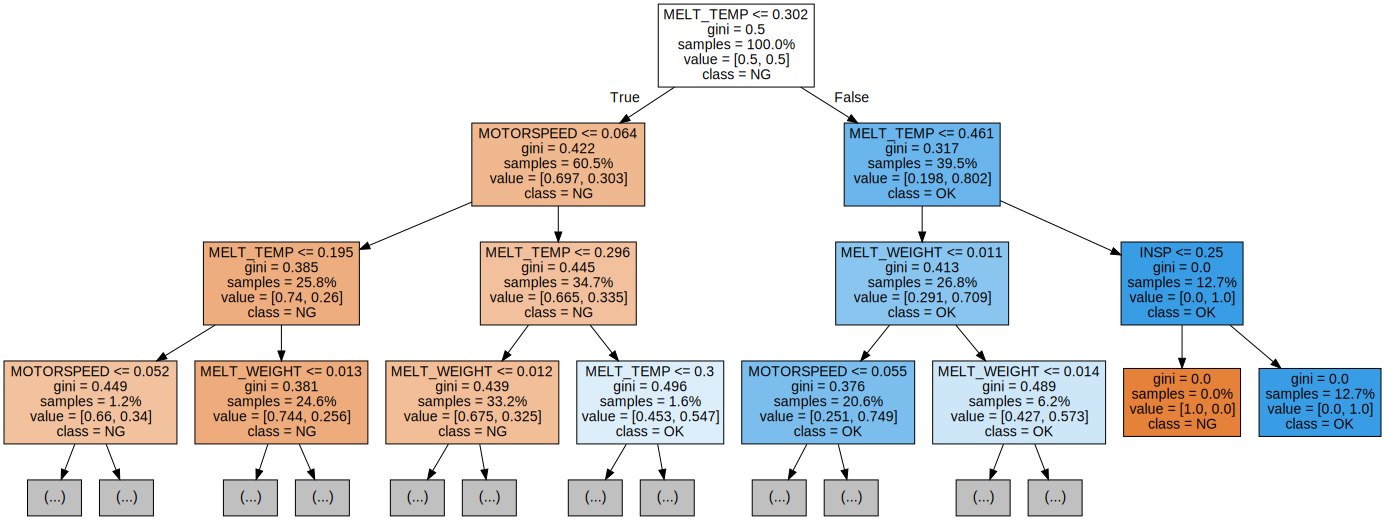

In [92]:
dot_data = export_graphviz(dsc
                          , max_depth=3
                          , feature_names=train_set_feature.columns
                          , class_names=['NG', 'OK']
                          , filled=True
                          , proportion=True)


display(graphviz.Source(dot_data))

# 랜덤포레스트(Random Forest)

In [170]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5)
clf.fit(x_train_over,y_train_over)

RandomForestClassifier(max_depth=5)

In [171]:
predict2 = clf.predict(x_test_values)
print('accuracy_score :', accuracy_score(y_test_values ,predict2))
print('f1_score :', f1_score(y_test_values, predict2))
print('precision : ', precision_score(y_test_values, predict2))
print('recall :', recall_score(y_test_values, predict2))

accuracy_score : 0.6833692528735632
f1_score : 0.7612398014921197
precision :  0.9388882290058201
recall : 0.6401214728584081


In [172]:
confusion_matrix(y_test, predict1)

array([[ 22565,  30420],
       [ 39629, 157946]], dtype=int64)

In [173]:
perm = PermutationImportance(clf).fit(x_test_values, y_test_values)
eli5.show_weights(perm, top = 4, feature_names = train_set_feature.columns.tolist())

Weight,Feature
0.0670 ± 0.0005,MELT_TEMP
0.0002 ± 0.0001,MELT_WEIGHT
-0.0005 ± 0.0001,INSP
-0.0204 ± 0.0010,MOTORSPEED


# Xgboost

In [138]:
import xgboost
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators = 300, learning_rate = 0.2, max_depth = 15, random_state = 1).fit(x_train_over, y_train_over)
predict4 = xgb.predict(x_test_values)

In [139]:
print('accuracy_score :', accuracy_score(y_test_values ,predict4))
print('f1_score :', f1_score(y_test_values, predict4))
print('precision : ', precision_score(y_test_values, predict4))
print('recall :', recall_score(y_test_values, predict4))

accuracy_score : 0.7632343550446998
f1_score : 0.8502675416456336
precision :  0.8480201384518565
recall : 0.8525268885233456


In [147]:
confusion_matrix(y_test, predict4)

array([[ 22798,  30187],
       [ 29137, 168438]], dtype=int64)

In [140]:
perm = PermutationImportance(xgb, scoring = "accuracy").fit(x_test_values, y_test_values)
eli5.show_weights(perm, top = 4, feature_names = train_set_feature.columns.tolist())

Weight,Feature
0.0411 ± 0.0009,MELT_TEMP
0.0137 ± 0.0013,MELT_WEIGHT
0.0000 ± 0.0010,INSP
-0.0017 ± 0.0004,MOTORSPEED


# Catboost

In [141]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(n_estimators=300).fit(x_train_over, y_train_over)
predict5= cb.predict(x_test_values)

Learning rate set to 0.5
0:	learn: 0.5481566	total: 64.4ms	remaining: 19.3s
1:	learn: 0.5300510	total: 124ms	remaining: 18.4s
2:	learn: 0.5186464	total: 180ms	remaining: 17.8s
3:	learn: 0.5161160	total: 237ms	remaining: 17.5s
4:	learn: 0.5150319	total: 295ms	remaining: 17.4s
5:	learn: 0.5139706	total: 353ms	remaining: 17.3s
6:	learn: 0.5132481	total: 422ms	remaining: 17.6s
7:	learn: 0.5124468	total: 490ms	remaining: 17.9s
8:	learn: 0.5118383	total: 556ms	remaining: 18s
9:	learn: 0.5108536	total: 623ms	remaining: 18.1s
10:	learn: 0.5104291	total: 698ms	remaining: 18.3s
11:	learn: 0.5081768	total: 767ms	remaining: 18.4s
12:	learn: 0.5079151	total: 839ms	remaining: 18.5s
13:	learn: 0.5055939	total: 906ms	remaining: 18.5s
14:	learn: 0.5039289	total: 971ms	remaining: 18.4s
15:	learn: 0.5024607	total: 1.03s	remaining: 18.3s
16:	learn: 0.5007998	total: 1.1s	remaining: 18.3s
17:	learn: 0.4993790	total: 1.16s	remaining: 18.2s
18:	learn: 0.4977919	total: 1.22s	remaining: 18.1s
19:	learn: 0.49680

163:	learn: 0.4620421	total: 10.5s	remaining: 8.69s
164:	learn: 0.4620087	total: 10.5s	remaining: 8.63s
165:	learn: 0.4619490	total: 10.6s	remaining: 8.57s
166:	learn: 0.4619147	total: 10.7s	remaining: 8.5s
167:	learn: 0.4618841	total: 10.7s	remaining: 8.44s
168:	learn: 0.4618534	total: 10.8s	remaining: 8.38s
169:	learn: 0.4618188	total: 10.9s	remaining: 8.32s
170:	learn: 0.4617854	total: 10.9s	remaining: 8.26s
171:	learn: 0.4617371	total: 11s	remaining: 8.2s
172:	learn: 0.4616945	total: 11.1s	remaining: 8.13s
173:	learn: 0.4616575	total: 11.1s	remaining: 8.07s
174:	learn: 0.4616223	total: 11.2s	remaining: 8.01s
175:	learn: 0.4615916	total: 11.3s	remaining: 7.95s
176:	learn: 0.4615314	total: 11.3s	remaining: 7.88s
177:	learn: 0.4614886	total: 11.4s	remaining: 7.82s
178:	learn: 0.4614612	total: 11.5s	remaining: 7.74s
179:	learn: 0.4614412	total: 11.5s	remaining: 7.67s
180:	learn: 0.4614129	total: 11.6s	remaining: 7.61s
181:	learn: 0.4613727	total: 11.6s	remaining: 7.55s
182:	learn: 0.46

In [142]:
print('accuracy_score :', accuracy_score(y_test_values ,predict5))
print('f1_score :', f1_score(y_test_values, predict5))
print('precision : ', precision_score(y_test_values, predict5))
print('recall :', recall_score(y_test_values, predict5))

accuracy_score : 0.6971424010217113
f1_score : 0.7775236889013979
precision :  0.9239720443444148
recall : 0.6711476654435025


In [148]:
confusion_matrix(y_test, predict5)

array([[ 42074,  10911],
       [ 64973, 132602]], dtype=int64)

In [143]:
perm = PermutationImportance(cb, scoring = "accuracy").fit(x_test_values, y_test_values)
eli5.show_weights(perm, top = 4, feature_names = train_set_feature.columns.tolist())

Weight,Feature
0.0699 ± 0.0013,MELT_TEMP
0.0103 ± 0.0005,MELT_WEIGHT
-0.0069 ± 0.0003,INSP
-0.0123 ± 0.0013,MOTORSPEED


# LightGBM

In [144]:
lgbm = LGBMClassifier(n_estimators=1000, max_depth=15, objective='binary', num_leaves = 30).fit(x_train_over, y_train_over)
predict6= lgbm.predict(x_test_values)

In [145]:
print('accuracy_score :', accuracy_score(y_test_values ,predict6))
print('f1_score :', f1_score(y_test_values, predict6))
print('precision : ', precision_score(y_test_values, predict6))
print('recall :', recall_score(y_test_values, predict6))

accuracy_score : 0.7065253831417625
f1_score : 0.7886527268807934
precision :  0.9125108081143998
recall : 0.694399595090472


In [150]:
confusion_matrix(y_test, predict6)

array([[ 39831,  13154],
       [ 60379, 137196]], dtype=int64)

In [146]:
perm = PermutationImportance(lgbm, scoring = "accuracy").fit(x_test_values, y_test_values)
eli5.show_weights(perm, top = 4, feature_names = train_set_feature.columns.tolist())

Weight,Feature
0.0641 ± 0.0012,MELT_TEMP
0.0127 ± 0.0005,MELT_WEIGHT
0.0008 ± 0.0005,INSP
-0.0153 ± 0.0009,MOTORSPEED
